# Import Libraries 

In [1]:
from os import listdir
from os.path import isfile, join

import tensorflow as tf

import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
logging.disable(sys.maxsize)
import random
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#import pydot_ng as pydot
#pydot.find_graphviz()

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False
})
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 15

# Import Data

In [2]:
data_dir = 'C:/Users/rubbi/OneDrive/ClassDocs/CS685PIML/data/B90_102/experiment_30m/HVAC_B90_102_exp_30m_20210426_5mins.csv'
data_df  = pd.read_csv(data_dir , index_col=0)

# Define functions for working with data

In [3]:
def train_test_split_multioutput(x_df, y_df, train_percent):
    x_len = len(x_df)
    y_len = len(y_df)
    x_indices = random.sample(range(0, x_len), int(x_len*train_percent))
    x_train = x_df.loc[x_indices]
    x_test = x_df.drop(x_indices)
    y_indices = random.sample(range(0, y_len), int(y_len*train_percent))
    y_train = y_df.loc[y_indices]
    y_test = y_df.drop(y_indices)
    x_train = x_train.reset_index()
    x_test = x_test.reset_index()
    y_train = y_train.reset_index()
    y_test = y_test.reset_index()
    return(x_train, x_test, y_train, y_test)



# Extract Relevant Data

C:\Users\rubbi\AppData\Local\Temp/ipykernel_8936/1693815236.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['sensible_heat_diff_ave'] = relevant_data['sensible_heat_in_ave'] - relevant_data['sensible_heat_room_ave']
C:\Users\rubbi\AppData\Local\Temp/ipykernel_8936/1693815236.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['prev_temp'] = relevant_data['room_temp_ave'].shift(1)


Text(0, 0.5, 'average room_temp difference')

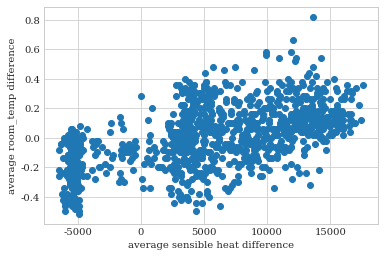

In [26]:
relevant_data = data_df[['room_temp_ave','thermostat_room_temp_ave', 'sensible_heat_in_ave', 'sensible_heat_room_ave', 
                         'setpoint', 'htg_valve_position_ave', 'airflow_current_ave',
                        'supply_discharge_temp_ave',
                        'thermostat_outside_temp_ave']]
 

relevant_data['sensible_heat_diff_ave'] = relevant_data['sensible_heat_in_ave'] - relevant_data['sensible_heat_room_ave']
relevant_data['prev_temp'] = relevant_data['room_temp_ave'].shift(1)
relevant_data.dropna(inplace=True)
relevant_data.reset_index(drop=True, inplace=True)

X = relevant_data[['prev_temp', 'sensible_heat_diff_ave', 'setpoint']]
Y = relevant_data[['room_temp_ave']]

room_temp_diff = relevant_data['room_temp_ave'] - relevant_data['prev_temp']

plt.rc('text', usetex=False)
plt.plot( relevant_data['sensible_heat_diff_ave'],room_temp_diff,'o')
plt.xlabel("average sensible heat difference")
plt.ylabel("average room_temp difference")




# Determine Monotonicity

C:\Users\rubbi\AppData\Local\Temp/ipykernel_20232/3200874621.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


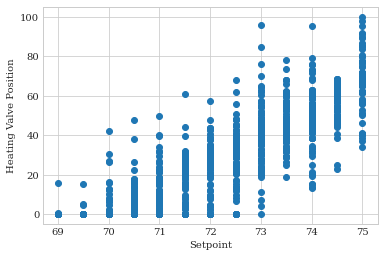

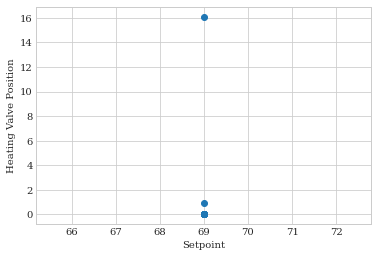

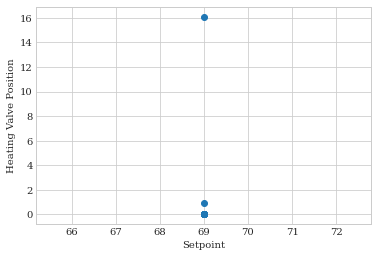

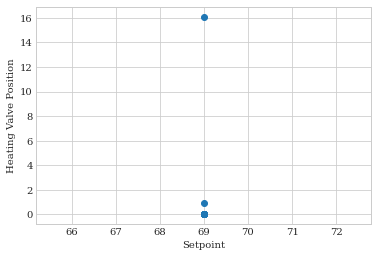

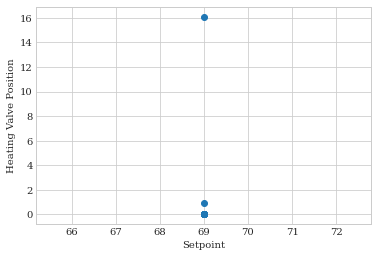

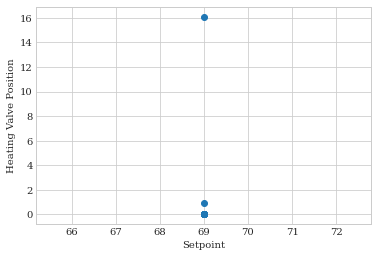

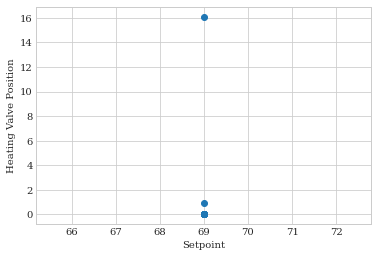

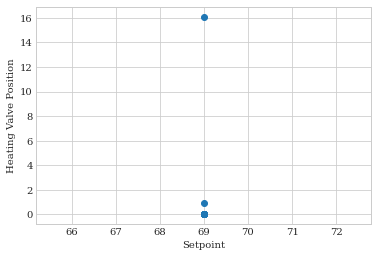

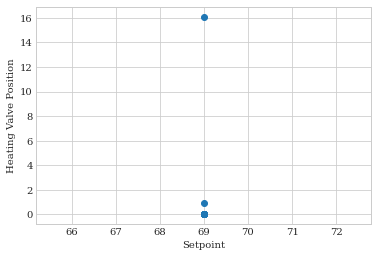

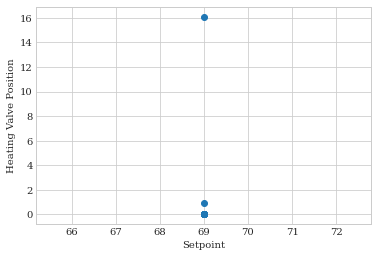

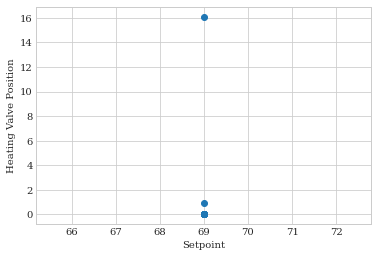

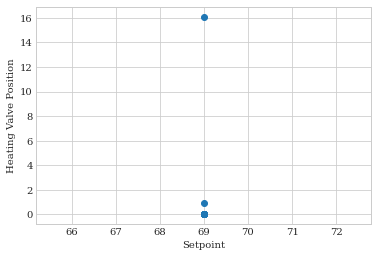

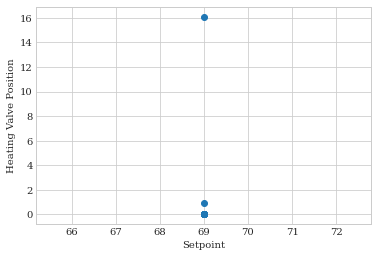

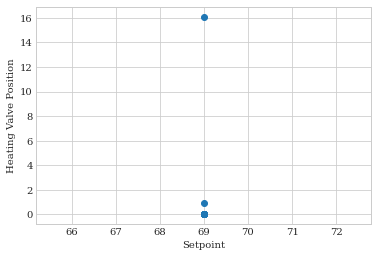

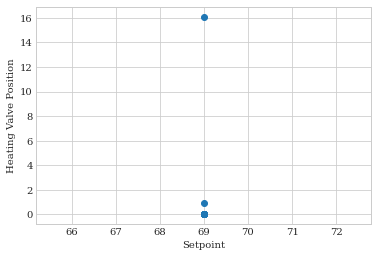

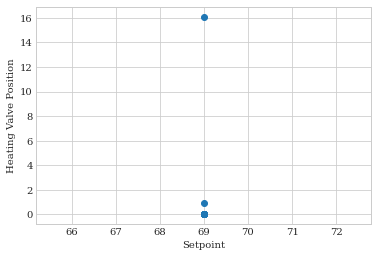

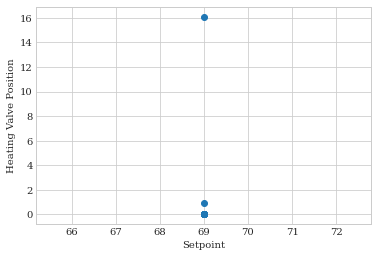

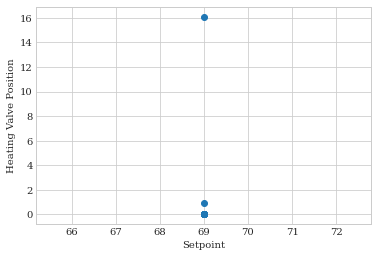

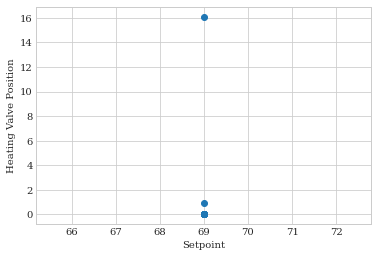

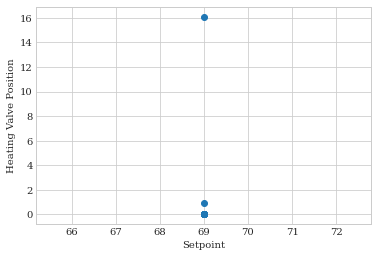

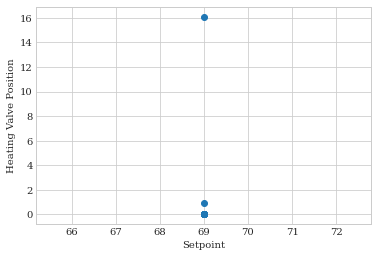

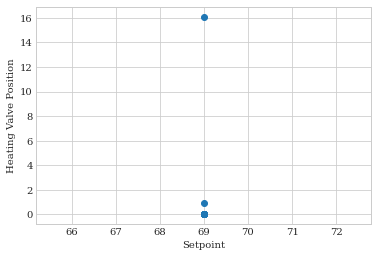

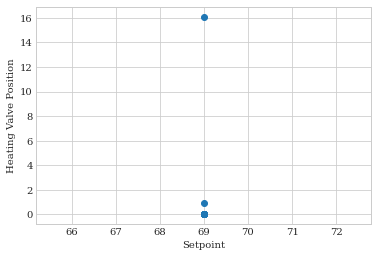

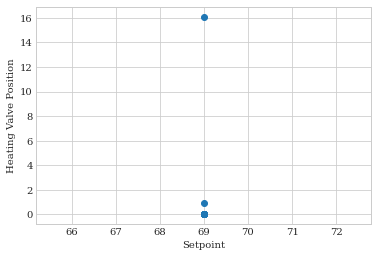

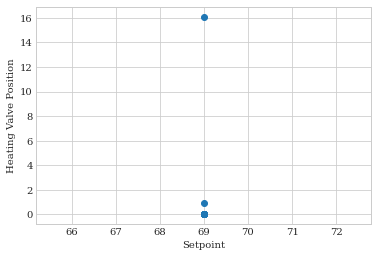

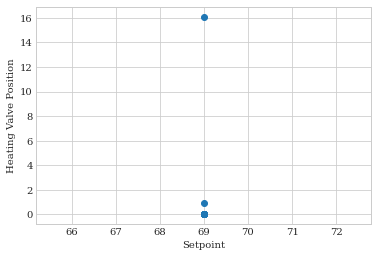

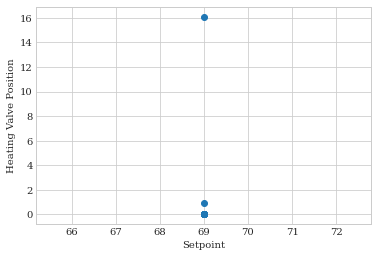

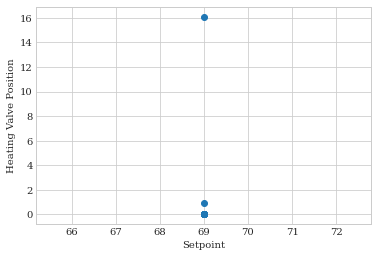

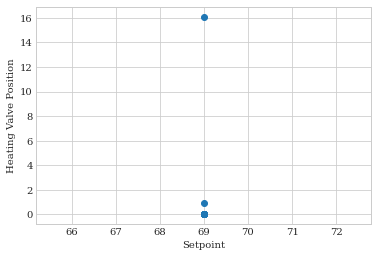

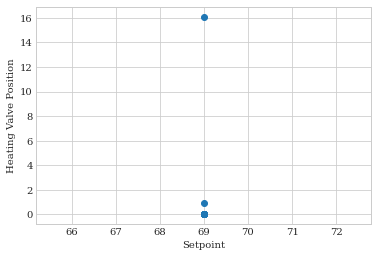

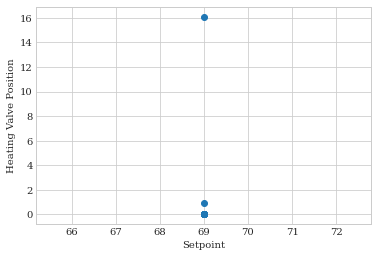

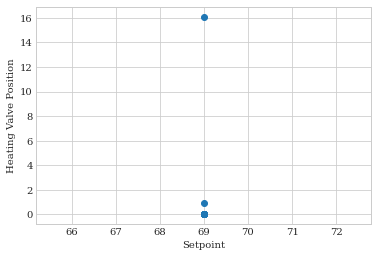

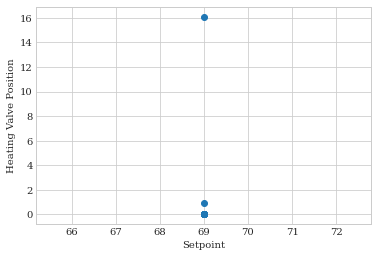

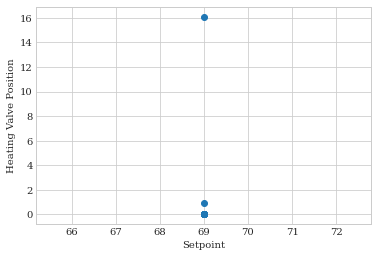

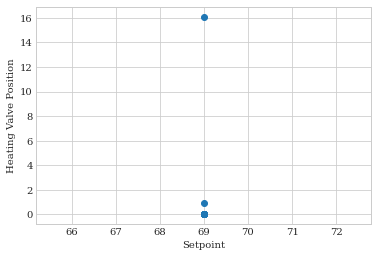

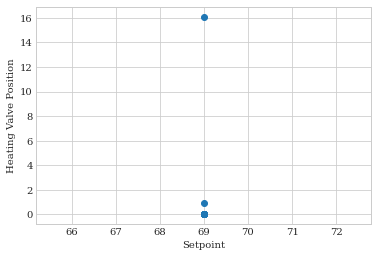

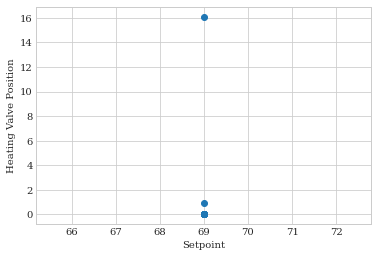

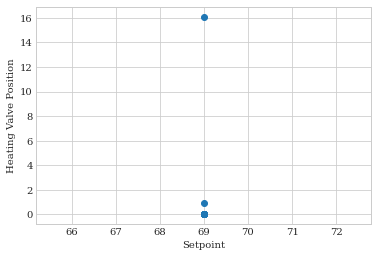

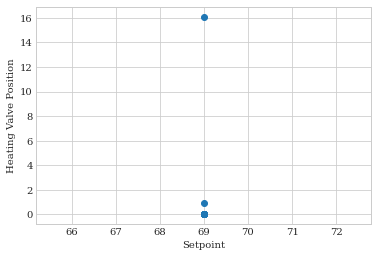

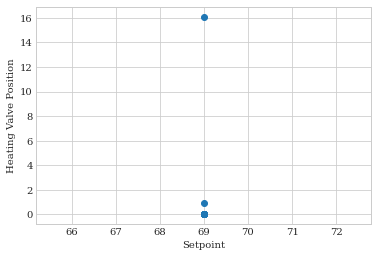

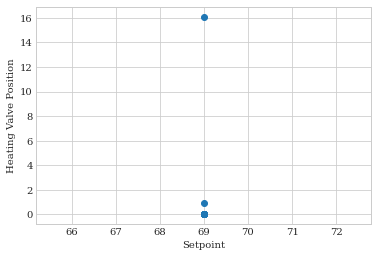

In [29]:
points_within_range = relevant_data[relevant_data['setpoint'].between(65, 75)]
plt.rc('text', usetex=False)
plt.plot(points_within_range['setpoint'], points_within_range['htg_valve_position_ave'],'o')
plt.xlabel("Setpoint")
plt.ylabel("Heating Valve Position")

prev_min = relevant_data['setpoint'].min()
prev_max = relevant_data['setpoint'].max()
for prev_temp_min in np.arange(prev_min,prev_max,0.2):
    plt.figure()
    points_within_range = relevant_data[relevant_data['setpoint'].between(prev_min, prev_min+0.1)]
    plt.rc('text', usetex=False)
    plt.plot(points_within_range['setpoint'], points_within_range['htg_valve_position_ave'],'o')
    plt.xlabel("Setpoint")
    plt.ylabel("Heating Valve Position")


# Split into training and testing

In [7]:
list(data_df.columns)


['thermostat_room_temp',
 'room_temp',
 'thermostat_outside_temp',
 'supply_discharge_temp',
 'ahu_supply_temp',
 'setpoint',
 'setpoint_max',
 'setpoint_min',
 'clg_sp_current',
 'htg_sp_current',
 'clg_sp_offset',
 'htg_sp_offset',
 'occupied_clg_sp',
 'occupied_htg_sp',
 'unoccupied_clg_sp',
 'unoccupied_htg_sp',
 'htg_valve_position',
 'htg_valve_command',
 'airflow_desired',
 'airflow_current',
 'airflow_max',
 'airflow_min',
 'damper_position',
 'damper_command',
 'damper_integral_factor',
 'htg_signal',
 'clg_signal',
 'htg_clg_mode',
 'occupied_status',
 'airflow_current_smooth',
 'room_temp_smooth',
 'supply_discharge_temp_smooth',
 'thermostat_outside_temp_smooth',
 'sensible_heat_in',
 'sensible_heat_room',
 'sensible_heat_in_smooth',
 'sensible_heat_room_smooth',
 'thermostat_room_temp_ave',
 'room_temp_ave',
 'thermostat_outside_temp_ave',
 'supply_discharge_temp_ave',
 'ahu_supply_temp_ave',
 'htg_valve_position_ave',
 'htg_valve_command_ave',
 'airflow_desired_ave',
 'ai

# Creating Calibrators and Inputs 

In [9]:
errs = []
random.seed(1)
for iter in range(1,20):
    X_train,X_test,y_train,y_test = train_test_split_multioutput(X,Y,0.66)

    lattice_sizes = [5,5]
    model_inputs = []
    lattice_inputs = []


    ########previous room temp calibrator#############
    prev_temp_input = tf.keras.layers.Input(shape=[1], name='prev_temp')
    model_inputs.append(prev_temp_input)
    prev_temp_calibrator = tfl.layers.PWLCalibration(
       input_keypoints = np.linspace(
          X_train['prev_temp'].min(), X_train['prev_temp'].max(), num=15),
        dtype=tf.float32,
        output_min=0.0,
        output_max=lattice_sizes[0]-1.0,
        kernel_initializer='equal_slopes',
        name='prev_temp_calib',
        kernel_regularizer=('wrinkle',0.0, 1e-4) 
    )(
        prev_temp_input)
    lattice_inputs.append(prev_temp_calibrator)

    ##########sensible heat difference calibrator##################
    sensible_heat_diff_input = tf.keras.layers.Input(shape=[1], name='sensible_heat_diff')
    model_inputs.append(sensible_heat_diff_input)
    sensible_heat_diff_calibrator = tfl.layers.PWLCalibration(
       input_keypoints = np.linspace(
              X_train['sensible_heat_diff_ave'].min(), X_train['sensible_heat_diff_ave'].max(), num=15),
        dtype=tf.float64,
        output_min=0.0,
        output_max=lattice_sizes[0]-1.0,
        name='sensible_heat_diff_calib',
        #kernel_regularizer=('wrinkle',0.0, 1e-4),
        monotonicity='increasing'
    )(
       sensible_heat_diff_input)
    lattice_inputs.append(sensible_heat_diff_calibrator)

    ##########setpoint calibrator####################
    setpoint_input = tf.keras.layers.Input(shape=[1], name='setpoint')
    #model_inputs.append(setpoint_input)
    setpoint_calibrator = tfl.layers.PWLCalibration(
       input_keypoints = np.linspace(
              X_train['setpoint'].min(), X_train['setpoint'].max(), num=15),
        dtype=tf.float64,
        output_min=0.0,
        output_max=lattice_sizes[0]-1.0,
        name='setpoint_calib',
        monotonicity='increasing'
    )(
      setpoint_input)
    #lattice_inputs.append(setpoint_calibrator)

    lattice = tfl.layers.Lattice(
        lattice_sizes = lattice_sizes,
        #monotonicities=['none', 'none'],
        monotonicities=['none', 'increasing'],
        output_min=y_train['room_temp_ave'].min(),
        output_max=y_train['room_temp_ave'].max(),
        name='lattice',
    )(
        lattice_inputs) 

    model = tf.keras.models.Model(
        inputs=model_inputs,
        outputs=lattice)
    feature_names = ['prev_temp', 'sensible_heat_diff_ave']
    #feature_names = ['prev_temp']

    features = np.split(
        X_train[feature_names].values,
        indices_or_sections=len(feature_names),
        axis=1)
    target=y_train['room_temp_ave'].values

    model.compile(
        loss=tf.keras.losses.mean_squared_error,
        optimizer=tf.keras.optimizers.Adam(0.1))
    model.fit(
        features,
        target,
        batch_size=8,
        epochs=100,
        shuffle=False,
        verbose=0)
    
    features_test = np.split(
        X_test[feature_names].values,
        indices_or_sections=len(feature_names),
        axis=1)

    errs.append(model.evaluate(features_test, y_test['room_temp_ave']))


13/13 [==============================] - 0s 500us/step - loss: 2.8535


KeyboardInterrupt: 

# Create Lattice Layer

In [20]:
np.mean(errs)
batch_sizes = range(10, 100, 5)
len(batch_sizes)

18

# Predicting Sensible Heat Input and Airflow with Multioutput Model

In [30]:
relevant_data['prev_thermostat_temp'] = relevant_data['thermostat_room_temp_ave'].shift(1)
relevant_data.dropna(inplace=True)
relevant_data.reset_index(drop=True, inplace=True)
X = relevant_data[['thermostat_room_temp_ave', 'thermostat_outside_temp_ave', 'setpoint']]
Y = relevant_data[['sensible_heat_in_ave', 'airflow_current_ave']]

C:\Users\rubbi\AppData\Local\Temp/ipykernel_8936/3276563259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['prev_thermostat_temp'] = relevant_data['thermostat_room_temp_ave'].shift(1)
C:\Users\rubbi\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [36]:
errs_air = []
errs_sens = []
batches = []
key1 = []
lattice1 = []

batch_sizes = range(2, 30, 2)
lattice_sizes = range(2, 10, 1)
keypoint_nums = range(2, 30, 2)

X_train,X_test,y_train,y_test = train_test_split_multioutput(X,Y,0.66)

for lattice_size in lattice_sizes:
    for keypoint_num in keypoint_nums:
        for batch_size in batch_sizes:

            lattice_sizes = [lattice_size, lattice_size, lattice_size]
            model_inputs = []
            lattice_inputs = []


            ########previous room temp calibrator#############
            temp_input = tf.keras.layers.Input(shape=[1], name='thermostat_room_temp_ave')
            model_inputs.append(temp_input)
            temp_calibrator = tfl.layers.PWLCalibration(
               input_keypoints = np.linspace(
                  X_train['thermostat_room_temp_ave'].min(), X_train['thermostat_room_temp_ave'].max(), num=keypoint_num),
                dtype=tf.float32,
                output_min=0.0,
                output_max=lattice_sizes[0]-1.0,
                kernel_initializer='equal_slopes',
                name='temp_calib',
                #kernel_regularizer=('wrinkle',0.0, 1e-4) 
            )(
                temp_input)
            lattice_inputs.append(temp_calibrator)

            ##########outside temperature calibrator##################
            thermostat_outside_input = tf.keras.layers.Input(shape=[1], name='thermostat_outside_temp_ave')
            model_inputs.append(thermostat_outside_input)
            thermostat_outside_temp_calibrator = tfl.layers.PWLCalibration(
               input_keypoints = np.linspace(
                      X_train['thermostat_outside_temp_ave'].min(), X_train['thermostat_outside_temp_ave'].max(), num=keypoint_num),
                dtype=tf.float64,
                output_min=0.0,
                output_max=lattice_sizes[0]-1.0,
                name='thermosat_outside_temp_calib',
                #kernel_regularizer=('wrinkle',0.0, 1e-4),
                #monotonicity='increasing'
            )(
               thermostat_outside_input)
            lattice_inputs.append(thermostat_outside_temp_calibrator)

            ##########setpoint calibrator####################
            setpoint_input = tf.keras.layers.Input(shape=[1], name='setpoint')
            model_inputs.append(setpoint_input)
            setpoint_calibrator = tfl.layers.PWLCalibration(
               input_keypoints = np.linspace(
                      X_train['setpoint'].min(), X_train['setpoint'].max(), num=keypoint_num),
                dtype=tf.float64,
                output_min=0.0,
                output_max=lattice_sizes[0]-1.0,
                name='setpoint_calib',
                monotonicity='increasing'
            )(
              setpoint_input)
            lattice_inputs.append(setpoint_calibrator)

            lattice = tfl.layers.Lattice(
                lattice_sizes = lattice_sizes,
                #monotonicities=['none', 'none'],
                monotonicities=['none', 'none', 'none'],
                #output_min=y_train['sensible_heat_in'].min(),
                #output_max=y_train['htg_valve_position_ave'].max(),
                name='lattice',
            )(
                lattice_inputs) 

            model = tf.keras.models.Model(
                inputs=model_inputs,
                outputs=lattice)
            feature_names = ['thermostat_room_temp_ave','thermostat_outside_temp_ave', 'setpoint']
            #feature_names = ['prev_temp']

            features = np.split(
                X_train[feature_names].values,
                indices_or_sections=len(feature_names),
                axis=1)
            target1=y_train['sensible_heat_in_ave'].values
            target2=y_train['airflow_current_ave'].values
            
            model.compile(
                loss=tf.keras.losses.mean_squared_error,
                optimizer=tf.keras.optimizers.Adam())
            model.fit(
                features,
                [target1, target2],
                batch_size=batch_size,
                epochs=200,
                shuffle=False,
                verbose=0)

            features_test = np.split(
                X_test[feature_names].values,
                indices_or_sections=len(feature_names),
                axis=1   
            )
            err = model.evaluate(features_test, y_test['airflow_current_ave'])
            err2 = model.evaluate(features_test, y_test['sensible_heat_in_ave'])
            errs_air.append(err)
            errs_sens.append(err2)
            batches.append(batch_size)
            key1.append(keypoint_num)
            lattice1.append(lattice_size)




13/13 [==============================] - 0s 500us/step - loss: 2601101568.0000


13/13 [==============================] - 0s 500us/step - loss: 2600869120.0000


13/13 [==============================] - 0s 500us/step - loss: 2600348672.0000


13/13 [==============================] - 0s 500us/step - loss: 2598216192.0000


13/13 [==============================] - 0s 500us/step - loss: 2601181184.0000


13/13 [==============================] - 0s 500us/step - loss: 2594927104.0000


KeyboardInterrupt: 

In [39]:
model.weights

[<tf.Variable 'temp_calib/pwl_calibration_kernel:0' shape=(18, 1) dtype=float32, numpy=
 array([[2.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)>,
 <tf.Variable 'thermosat_outside_temp_calib/pwl_calibration_kernel:0' shape=(18, 1) dtype=float64, numpy=
 array([[2.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])>,
 <tf.Variable 'setpoint_calib/pwl_calibration_kernel:0' shape=(18, 1) dtype=float64, numpy=
 array([[1.70239453e+00],
        [2.97596798e-01],
        [8.67440793e-06],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
       

# Test Multioutput Model

In [15]:

model.evaluate(features_test, y_test['sensible_heat_in_ave'])
model.evaluate(features_test, y_test['airflow_current_ave'])


13/13 [==============================] - 0s 500us/step - loss: 287089.4688


287089.46875

# Airflow Model

In [43]:
relevant_data['prev_thermostat_temp'] = relevant_data['thermostat_room_temp_ave'].shift(1)
relevant_data.dropna(inplace=True)
relevant_data.reset_index(drop=True, inplace=True)
X = relevant_data[['thermostat_room_temp_ave','setpoint', 'thermostat_outside_temp_ave']]
Y = relevant_data[[ 'airflow_current_ave']]

C:\Users\rubbi\AppData\Local\Temp/ipykernel_8936/3587389420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['prev_thermostat_temp'] = relevant_data['thermostat_room_temp_ave'].shift(1)


In [ ]:
errs_air = []
batches = []
key1 = []
lattice1 = []

batch_sizes = range(2, 30, 2)
lattice_sizes = range(2, 10, 1)
keypoint_nums = range(2, 30, 2)

X_train,X_test,y_train,y_test = train_test_split_multioutput(X,Y,0.66)

for lattice_size in lattice_sizes:
    for keypoint_num in keypoint_nums:
        for batch_size in batch_sizes:
            lattice_sizes = [lattice_size, lattice_size, lattice_size]
            model_inputs = []
            lattice_inputs = []


            ########previous room temp calibrator#############
            temp_input = tf.keras.layers.Input(shape=[1], name='thermostat_room_temp_ave')
            model_inputs.append(temp_input)
            temp_calibrator = tfl.layers.PWLCalibration(
               input_keypoints = np.linspace(
                  X_train['thermostat_room_temp_ave'].min(), X_train['thermostat_room_temp_ave'].max(), num=keypoint_num),
                dtype=tf.float32,
                output_min=0.0,
                output_max=lattice_sizes[0]-1.0,
                kernel_initializer='equal_slopes',
                name='temp_calib',
                #kernel_regularizer=('wrinkle',0.0, 1e-4) 
            )(
                temp_input)
            lattice_inputs.append(temp_calibrator)


            ##########outside temperature calibrator##################
            thermostat_outside_input = tf.keras.layers.Input(shape=[1], name='thermostat_outside_temp_ave')
            model_inputs.append(thermostat_outside_input)
            thermostat_outside_temp_calibrator = tfl.layers.PWLCalibration(
               input_keypoints = np.linspace(
                      X_train['thermostat_outside_temp_ave'].min(), X_train['thermostat_outside_temp_ave'].max(), num=keypoint_num),
                dtype=tf.float64,
                output_min=0.0,
                output_max=lattice_sizes[0]-1.0,
                name='thermosat_outside_temp_calib',
                #kernel_regularizer=('wrinkle',0.0, 1e-4),
                #monotonicity='increasing'
            )(
               thermostat_outside_input)
            lattice_inputs.append(thermostat_outside_temp_calibrator)
            
            
            ##########setpoint calibrator####################
            setpoint_input = tf.keras.layers.Input(shape=[1], name='setpoint')
            model_inputs.append(setpoint_input)
            setpoint_calibrator = tfl.layers.PWLCalibration(
               input_keypoints = np.linspace(
                      X_train['setpoint'].min(), X_train['setpoint'].max(), num=keypoint_num),
                dtype=tf.float64,
                output_min=0.0,
                output_max=lattice_sizes[0]-1.0,
                name='setpoint_calib',
                #monotonicity='increasing'
            )(
              setpoint_input)
            lattice_inputs.append(setpoint_calibrator)

            lattice = tfl.layers.Lattice(
                lattice_sizes = lattice_sizes,
                #monotonicities=['none', 'none'],
                monotonicities=['none', 'none', 'none'],
                output_min=y_train['airflow_current_ave'].min(),
                output_max=y_train['airflow_current_ave'].max(),
                name='lattice',
            )(
                lattice_inputs) 

            model = tf.keras.models.Model(
                inputs=model_inputs,
                outputs=lattice)
            feature_names = ['thermostat_room_temp_ave', 'thermostat_outside_temp_ave', 'setpoint']
            #feature_names = ['prev_temp']

            features = np.split(
                X_train[feature_names].values,
                indices_or_sections=len(feature_names),
                axis=1)
            target=y_train['airflow_current_ave'].values

            model.compile(
                loss=tf.keras.losses.mean_squared_error,
                optimizer=tf.keras.optimizers.Adam())
            model.fit(
                features,
                target,
                batch_size=batch_size,
                epochs=200,
                shuffle=False,
                verbose=0)

            features_test = np.split(
                X_test[feature_names].values,
                indices_or_sections=len(feature_names),
                axis=1   
            )
   
          
            model.evaluate(features_test, y_test['airflow_current_ave'])



13/13 [==============================] - 0s 500us/step - loss: 24407.5742


13/13 [==============================] - 0s 500us/step - loss: 26297.7480


In [21]:
features_test = np.split(
        X_test[feature_names].values,
        indices_or_sections=len(feature_names),
        axis=1)
model.evaluate(features_test, y_test['airflow_current_ave'])

13/13 [==============================] - 0s 500us/step - loss: 24864.4258


24864.42578125

# Cross-Validation for Heating Valve Position Model

In [ ]:
relevant_data['prev_thermostat_temp'] = relevant_data['thermostat_room_temp_ave'].shift(1)
relevant_data.dropna(inplace=True)
relevant_data.reset_index(drop=True, inplace=True)
X = relevant_data[['thermostat_room_temp_ave','setpoint']]
Y = relevant_data[['htg_valve_position_ave']]

errs = []
batches = []
lattice1 = []
lattice2 = []
key1 = []
key2 = []
batch_sizes = range(2, 30, 2)
lattice_sizes = range(2, 10, 1)
keypoint_nums = range(2, 30, 2)


X_train,X_test,y_train,y_test = train_test_split_multioutput(X,Y,0.66)

for batch_size in batch_sizes:
    for lattice_size1 in lattice_sizes:
        for lattice_size2 in lattice_sizes:
            for keypoint1 in keypoint_nums:
                for keypoint2 in keypoint_nums:
                
                        lattice_sizes = [lattice_size1, lattice_size2]
                        model_inputs = []
                        lattice_inputs = []


                        ########previous room temp calibrator#############
                        temp_input = tf.keras.layers.Input(shape=[1], name='thermostat_room_temp_ave')
                        model_inputs.append(temp_input)
                        temp_calibrator = tfl.layers.PWLCalibration(
                           input_keypoints = np.linspace(
                              X_train['thermostat_room_temp_ave'].min(), X_train['thermostat_room_temp_ave'].max(), num=keypoint1),
                            dtype=tf.float32,
                            output_min=0.0,
                            output_max=lattice_sizes[0]-1.0,
                            #kernel_initializer='equal_slopes',
                            name='temp_calib',
                            #kernel_regularizer=('wrinkle',0.0, 1e-4) 
                        )(
                            temp_input)
                        lattice_inputs.append(temp_calibrator)

                        ##########sensible heat difference calibrator##################
                        supply_discharge_input = tf.keras.layers.Input(shape=[1], name='supply_discharge')
                        #model_inputs.append(supply_discharge_input)
                        #supply_discharge_temp_calibrator = tfl.layers.PWLCalibration(
                        #   input_keypoints = np.linspace(
                        #          X_train['supply_discharge_temp_ave'].min(), X_train['supply_discharge_temp_ave'].max(), num=30),
                        #    dtype=tf.float64,
                        #    output_min=0.0,
                        #    output_max=lattice_sizes[0]-1.0,
                        #    name='supply_discharge_temp_calib',
                        #    #kernel_regularizer=('wrinkle',0.0, 1e-4),
                        #    monotonicity='increasing'
                        #)(
                        #   supply_discharge_input)
                        #lattice_inputs.append(supply_discharge_temp_calibrator)

                        ##########setpoint calibrator####################
                        setpoint_input = tf.keras.layers.Input(shape=[1], name='setpoint')
                        model_inputs.append(setpoint_input)
                        setpoint_calibrator = tfl.layers.PWLCalibration(
                           input_keypoints = np.linspace(
                                  X_train['setpoint'].min(), X_train['setpoint'].max(), num=keypoint2),
                            dtype=tf.float64,
                            output_min=0.0,
                            output_max=lattice_sizes[0]-1.0,
                            name='setpoint_calib',
                            monotonicity='increasing'
                        )(
                          setpoint_input)
                        lattice_inputs.append(setpoint_calibrator)

                        lattice = tfl.layers.Lattice(
                            lattice_sizes = lattice_sizes,
                            #monotonicities=['none', 'none'],
                            monotonicities=['none', 'increasing'],
                            output_min=y_train['htg_valve_position_ave'].min(),
                            output_max=y_train['htg_valve_position_ave'].max(),
                            name='lattice',
                        )(
                            lattice_inputs) 

                        model = tf.keras.models.Model(
                            inputs=model_inputs,
                            outputs=lattice)
                        feature_names = ['thermostat_room_temp_ave', 'setpoint']
                        #feature_names = ['prev_temp']

                        features = np.split(
                            X_train[feature_names].values,
                            indices_or_sections=len(feature_names),
                            axis=1)
                        target=y_train['htg_valve_position_ave'].values

                        model.compile(
                            loss=tf.keras.losses.mean_squared_error,
                            optimizer=tf.keras.optimizers.Adam())
                        model.fit(
                            features,
                            target,
                            batch_size=batch_size,
                            epochs=100,
                            shuffle=False,
                            verbose=0)

                        features_test = np.split(
                            X_test[feature_names].values,
                            indices_or_sections=len(feature_names),
                            axis=1   
                        )
                    
                        err = model.evaluate(features_test, y_test['htg_valve_position_ave'])
                        errs.append(err)
                        batches.append(batch_size)
                        key1.append(keypoint1)
                        key2.append(keypoint2)
                        lattice1.append(lattice_size1)
                        lattice2.append(lattice_size2)
                        

C:\Users\rubbi\AppData\Local\Temp/ipykernel_20232/549300572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['prev_thermostat_temp'] = relevant_data['thermostat_room_temp_ave'].shift(1)


12/12 [==============================] - 0s 455us/step - loss: 661.6893


12/12 [==============================] - 0s 455us/step - loss: 660.2589


12/12 [==============================] - 0s 546us/step - loss: 668.3952


12/12 [==============================] - 0s 455us/step - loss: 672.8070


12/12 [==============================] - 0s 546us/step - loss: 675.4841


In [94]:
model.get_weights()
tf.keras.utils.plot_model(model, rankdir='LR')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [2]:
min_val = min(errs)
print(min.index(min_val))

NameError: name 'errs' is not defined

# View Performance on Training Set

In [22]:

features_test = np.split(
    X_test[feature_names].values,
    indices_or_sections=len(feature_names),
    axis=1)

model.evaluate(features_test, y_test['room_temp_ave'])

13/13 [==============================] - 0s 750us/step - loss: 3.6736


3.673640727996826